## Notebook implementation: High-dimensional statistical arbitrage with factor models and stochastic control
### Paper author: Jorge Guijarro-Ordonez

This notebook is based on the above mentioned paper

In [1]:
# TODO:
# - Exponential utility with dollar neutrality does not work
# - RL part does not work

In [143]:
import numpy as np
from scipy.linalg import eig, inv, cholesky
from OU_simulation import *
from Policy_Gradient_agent import *
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.integrate import odeint
%reload_ext autoreload
%autoreload 2

### Part 1: Monte carlo simulations of high dimensional Ornstein-Uhlenbeck processes

In [176]:
# Same parameters are used as in the paper 
N       = 1
T       = 40
L       = 800
delta_t = T/L
theta   = np.diag(np.random.normal(0.5, 0.1, N))
mu      = np.zeros((N,1))
sigma   = np.random.uniform(-0.3,0.3,(N,N))
sigma   = sigma - np.diag(sigma.diagonal()) + np.diag(np.random.uniform(0,0.5,N))

In [177]:
# Initialise the process
process = ornstein_uhlenbeck_process(theta,mu,sigma,delta_t)
X       = np.zeros((N,L))
Y       = np.zeros((N,L))

# Perform a monte carlo simulation
for idx in range(L):
    X[:,idx] = process.step()
    Y[:,idx] = process.Yt

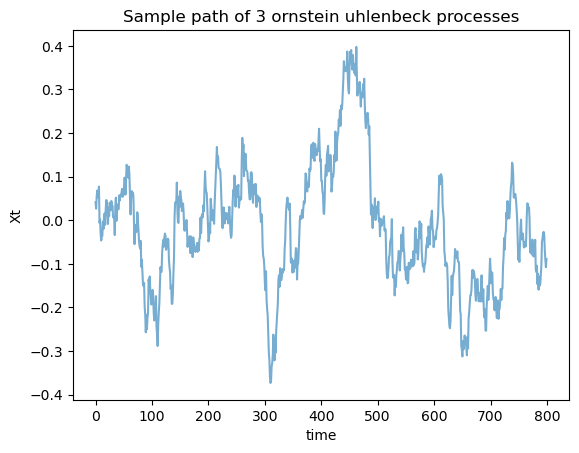

In [178]:
plt.plot(np.transpose(X[:3,:]),alpha=0.6)
plt.title('Sample path of 3 ornstein uhlenbeck processes')
plt.xlabel('time')
plt.ylabel('Xt')
plt.show()

### Part 2: stochastic control solutions applied to the monte carlo paths

#### 2.1 Exponential utility strategy & Mean variance case

In [185]:
r  = 0.02 # 2% interest rate
p  = np.ones((N,1)) #simplification in this model the asset prices themselves are assumed to be mean reverting
M  = 100 # amount of monte carlo simulations done
W0 = 0
gammas = [1,2,3,4]
Wealth_EU = np.zeros((M,L,len(gammas)))
Wealth_MV = np.zeros((M,L,len(gammas)))


# repeat the monte carlo simulation M times
for sim in tqdm(range(M)):
    X        = np.zeros((N,L))
    pi_EU       = np.zeros((N,L,len(gammas)))
    pi_MV       = np.zeros((N,L,len(gammas)))
    W_EU        = np.zeros((L,len(gammas)))
    W_MV        = np.zeros((L,len(gammas)))
    W_EU[:,0]   = W0
    W_MV[:,0]   = W0

    # initialise the process at t=0
    process = ornstein_uhlenbeck_process(theta,mu,sigma,delta_t)
    for idx in range(L):
        # perform a simulation for one time step
        X_t  = process.step().reshape((-1,1))
        t    = process.t
        X[:,idx] = X_t.reshape((1,-1))

        # calculate the change to the wealth
        if idx > 0:
            for count, gamma in enumerate(gammas):
                dW_t_EU = pi_EU[:,idx-1,count].transpose().dot(X[:,idx] - X[:,idx-1]) + (W_EU[idx-1,count] - pi_EU[:,idx-1,count].transpose() @ p)*r * delta_t
                W_EU[idx,count] = W_EU[idx-1,count] + dW_t_EU

                dW_t_MV = pi_MV[:,idx-1,count].transpose().dot(X[:,idx] - X[:,idx-1]) + (W_MV[idx-1,count] - pi_MV[:,idx-1,count].transpose() @ p)*r * delta_t
                W_MV[idx,count] = W_MV[idx-1,count] + dW_t_MV
        
        # Simulating the exponential-utility strategy
        sigma_perp_inv = inv(sigma @ sigma.transpose())
        for count, gamma in enumerate(gammas):
            pi_t_EU = sigma_perp_inv @ (theta @ (mu - X_t) - p*r) / (gamma*np.exp(r*(T-t))) + theta.transpose() @ (sigma_perp_inv) /(gamma*np.exp(r*(T-t))) @ (theta @ (mu-X_t) - p*r) * (T-t) - theta @ p *r*(T-t)**2/2
            pi_t_MV = inv(gamma*np.exp(2*r*(T-t))*sigma @ sigma.transpose()) @ (theta @ (mu - X_t) - p * r)*np.exp(r*(T-t))

            pi_EU[:,idx, count] = pi_t_EU.reshape((1,-1))
            pi_MV[:,idx, count] = pi_t_MV.reshape((1,-1))


    Wealth_EU[sim,:,:] = W_EU
    Wealth_MV[sim,:,:] = W_MV

100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


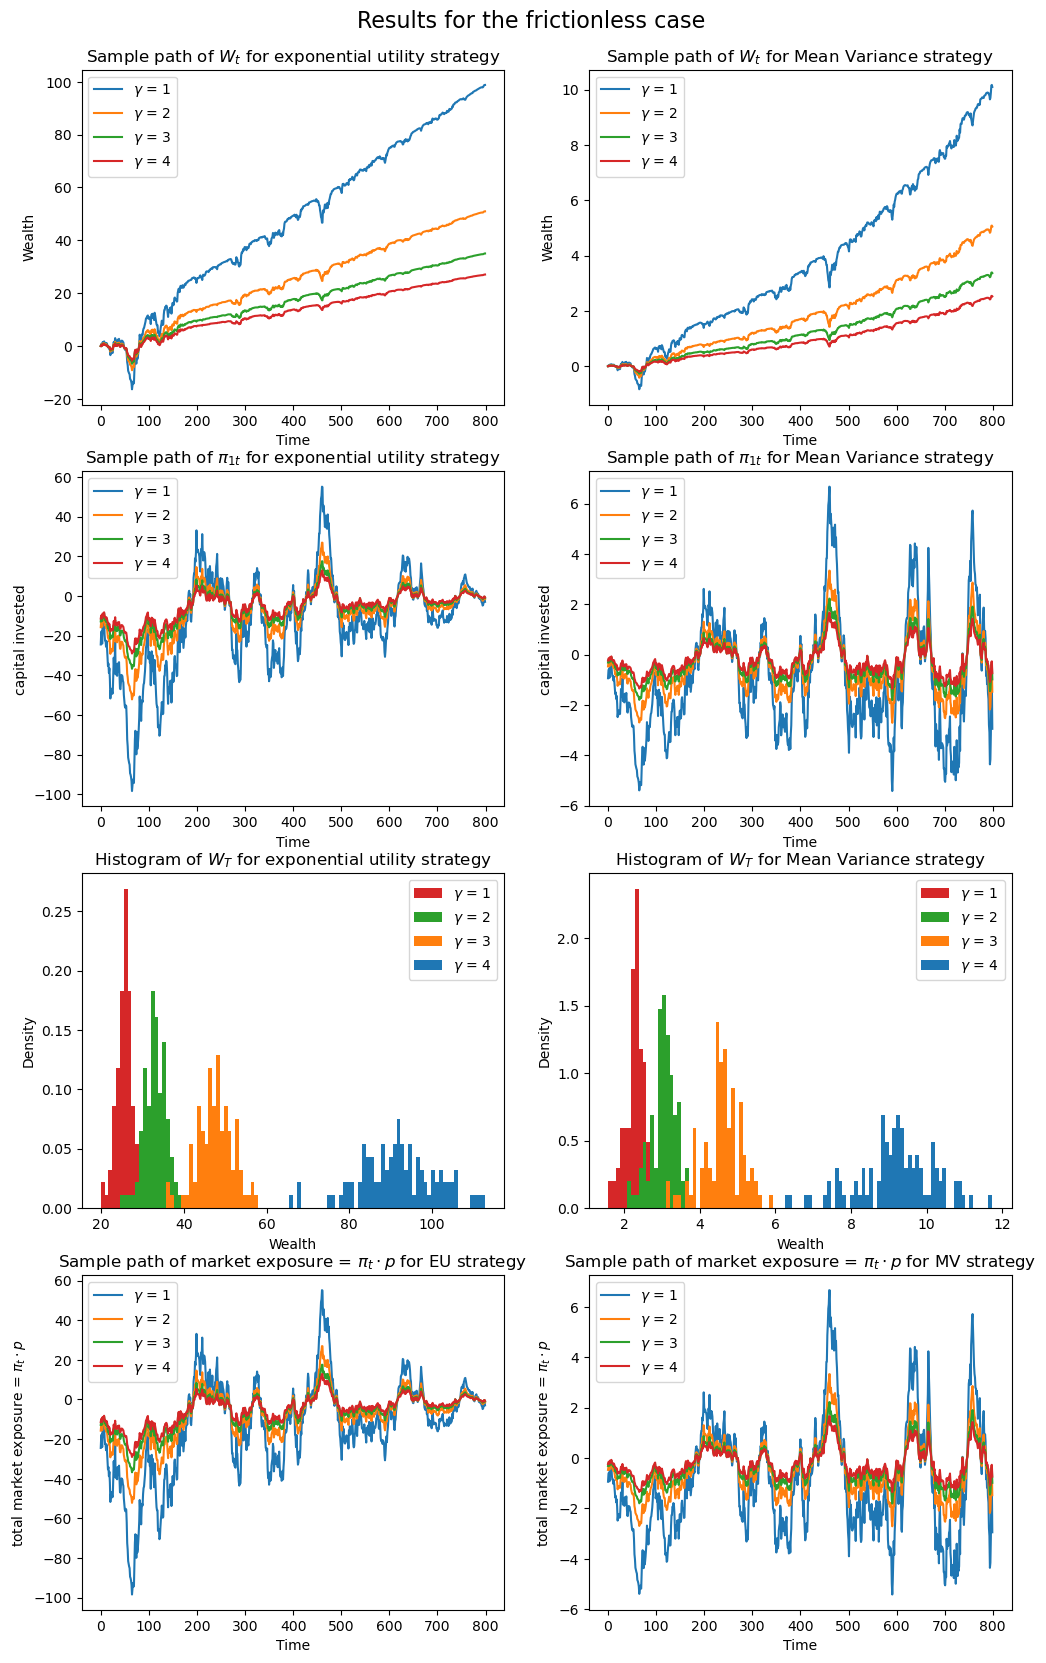

In [186]:
fig, ax = plt.subplots(4,2,figsize=(12,20))
fig.suptitle('Results for the frictionless case', fontsize=16, y = 0.91)
# plot a sample path of the wealth
ax[0,0].plot(Wealth_EU[-1,:,:])
ax[0,0].legend([r'$\gamma$ = 1',r'$\gamma$ = 2',r'$\gamma$ = 3',r'$\gamma$ = 4'])
ax[0,0].set_title(r'Sample path of $W_t$ for exponential utility strategy')
ax[0,0].set_ylabel('Wealth')
ax[0,0].set_xlabel('Time')

ax[0,1].plot(Wealth_MV[-1,:,:])
ax[0,1].legend([r'$\gamma$ = 1',r'$\gamma$ = 2',r'$\gamma$ = 3',r'$\gamma$ = 4'])
ax[0,1].set_title(r'Sample path of $W_t$ for Mean Variance strategy')
ax[0,1].set_ylabel('Wealth')
ax[0,1].set_xlabel('Time')

# plot a sample path of the capital invested in the first asset 
ax[1,0].plot(pi_EU[0,:,:])
ax[1,0].legend([r'$\gamma$ = 1',r'$\gamma$ = 2',r'$\gamma$ = 3',r'$\gamma$ = 4'])
ax[1,0].set_title(r'Sample path of $\pi_{1t}$ for exponential utility strategy')
ax[1,0].set_ylabel('capital invested')
ax[1,0].set_xlabel('Time')

ax[1,1].plot(pi_MV[0,:,:])
ax[1,1].legend([r'$\gamma$ = 1',r'$\gamma$ = 2',r'$\gamma$ = 3',r'$\gamma$ = 4'])
ax[1,1].set_title(r'Sample path of $\pi_{1t}$ for Mean Variance strategy')
ax[1,1].set_ylabel('capital invested')
ax[1,1].set_xlabel('Time')


# plot the density
ax[2,0].hist(Wealth_EU[:,-1,:],bins=100, density=True,histtype='stepfilled')
ax[2,0].legend([r'$\gamma$ = 1',r'$\gamma$ = 2',r'$\gamma$ = 3',r'$\gamma$ = 4'])
ax[2,0].set_title(r'Histogram of $W_T$ for exponential utility strategy')
ax[2,0].set_xlabel('Wealth')
ax[2,0].set_ylabel('Density')

ax[2,1].hist(Wealth_MV[:,-1,:],bins=100, density=True,histtype='stepfilled')
ax[2,1].legend([r'$\gamma$ = 1',r'$\gamma$ = 2',r'$\gamma$ = 3',r'$\gamma$ = 4'])
ax[2,1].set_title(r'Histogram of $W_T$ for Mean Variance strategy')
ax[2,1].set_xlabel('Wealth')
ax[2,1].set_ylabel('Density')

# plot the total market allocation
ax[3,0].plot(pi_EU.sum(axis=0))
ax[3,0].legend([r'$\gamma$ = 1',r'$\gamma$ = 2',r'$\gamma$ = 3',r'$\gamma$ = 4'])
ax[3,0].set_title(r'Sample path of market exposure = $\pi_t \cdot p$ for EU strategy')
ax[3,0].set_xlabel('Time')
ax[3,0].set_ylabel(r'total market exposure = $\pi_t \cdot p$ ')

ax[3,1].plot(pi_MV.sum(axis=0))
ax[3,1].legend([r'$\gamma$ = 1',r'$\gamma$ = 2',r'$\gamma$ = 3',r'$\gamma$ = 4'])
ax[3,1].set_title(r'Sample path of market exposure = $\pi_t \cdot p$ for MV strategy')
ax[3,1].set_xlabel('Time')
ax[3,1].set_ylabel(r'total market exposure = $\pi_t \cdot p$ ')

plt.show()

#### 2.2 Imposing dollar neutrality

In [187]:
import scipy.integrate

In [190]:
r  = 0.02 # 0.2% interest rate
p  = np.ones((N,1)) #simplification in this model the asset prices themselves are assumed to be mean reverting
M  = 100 # amount of monte carlo simulations done
W0 = 0
gammas = [1,2,3,4]
alpha  = 50 # market neutrality penalty
Wealth_EU = np.zeros((M,L,len(gammas)))
Wealth_MV = np.zeros((M,L,len(gammas)))

# I need to solve a ricatti matrix ODE, and a linear system of ODE's for use later on
C = np.zeros((N,N,L,len(gammas)))
b = np.zeros((N,L,len(gammas)))
for count, gamma in enumerate(gammas):
    print(count)
    # first Ricatti ODE
    def odefunc1(u,c, sigma, theta, r, gamma, alpha, p ): # u = T-t
        c     = c.reshape((N,N))
        sigma_sigma_transpose = sigma @ sigma.transpose()
        dc_du = theta.transpose() @ c + c @ theta + gamma * c @ sigma_sigma_transpose @ c - np.exp(r*u) \
            * (theta + gamma * sigma_sigma_transpose @ c).transpose() @ inv(gamma* sigma_sigma_transpose * np.exp(r*u) + alpha * p @ p.transpose()) \
            @ (theta + gamma * sigma_sigma_transpose @ c) 
        return dc_du.reshape(-1)
    
    func1 = lambda c,u: odefunc1(c,u, sigma, theta, r, gamma, alpha,p)

    sol = scipy.integrate.solve_ivp(method='RK23', fun=func1,y0=np.zeros(N*N),t_eval=np.linspace(0,T,L),t_span=(0,T),dense_output=False)
    C[:,:,:,count] = sol.y.reshape((N,N,L)) # Remember the values need to be accessed in reverse order on the time axis!!
    
    # second linear system of ODE's
    # def odefunc2(u,b, theta, mu,r, gamma, sigma, p, C, count, time_space):
    #     val = min(time_space, key=lambda x: np.abs(x - u))
    #     idx = np.where(time_space == val)[0][0]
    #     c = C[:,:,idx,count]
    #     b = b.reshape((N,1))
    #     db_du = theta.transpose() @ b - c @ theta @ mu - np.exp(r*u) * \
    #         (theta + gamma * sigma @ sigma.transpose() @ c) @ \
    #             inv(gamma * sigma @ sigma.transpose()*np.exp(r*u) + alpha * p @ p.transpose()) @ \
    #             (theta @ mu - p * r - gamma * sigma @ sigma.transpose() @ b) + gamma * c @ sigma @ sigma.transpose() @ b
    #     return db_du.reshape(-1)
    
    # func2 = lambda u,b: odefunc2(u,b,theta, mu,r, gamma, sigma, p, C, count, np.linspace(0,T,L))
    # sol = scipy.integrate.solve_ivp(method='Radau', fun=func2, y0=np.zeros(N),t_eval=np.linspace(0,T,L),t_span=(0,T),dense_output=False)
    # b[:,:,count] = sol.y
    
# repeat the monte carlo simulation M times
for sim in tqdm(range(M)):
    X        = np.zeros((N,L))
    pi_EU       = np.zeros((N,L,len(gammas)))
    pi_MV       = np.zeros((N,L,len(gammas)))
    W_EU        = np.zeros((L,len(gammas)))
    W_MV        = np.zeros((L,len(gammas)))
    W_EU[:,0]   = W0
    W_MV[:,0]   = W0

    # initialise the process at t=0
    process = ornstein_uhlenbeck_process(theta,mu,sigma,delta_t)
    for idx in range(L):
        # perform a simulation for one time step
        X_t  = process.step().reshape((-1,1))
        t    = process.t
        X[:,idx] = X_t.reshape((1,-1))

        # calculate the change to the wealth
        if idx > 0:
            for count, gamma in enumerate(gammas):
                dW_t_EU = pi_EU[:,idx-1,count].transpose().dot(X[:,idx] - X[:,idx-1]) + (W_EU[idx-1,count] - pi_EU[:,idx-1,count].transpose() @ p)*r * delta_t
                W_EU[idx,count] = W_EU[idx-1,count] + dW_t_EU

                dW_t_MV = pi_MV[:,idx-1,count].transpose().dot(X[:,idx] - X[:,idx-1]) + (W_MV[idx-1,count] - pi_MV[:,idx-1,count].transpose() @ p)*r * delta_t
                W_MV[idx,count] = W_MV[idx-1,count] + dW_t_MV
        
        # Simulating the exponential-utility and mean variance strategy
        sigma_perp_inv = inv(sigma @ sigma.transpose())
        for count, gamma in enumerate(gammas):
            pi_t_MV = inv(gamma * np.exp(r*(T-t)) * sigma @ sigma.transpose() + alpha * p @ p.transpose()) @ \
                (theta @ (mu - X_t) - p*r)*np.exp(r*(T-t))
            pi_t_EU = -1*inv(gamma*np.exp(r*(T-t))*sigma @ sigma.transpose() + alpha * p @ p.transpose()) @ \
                (theta @ (mu - X_t) - p * r - gamma * sigma @ sigma.transpose() @ (C[:,:,-idx-1,count] @ X_t+ b[:,-idx-1,count].reshape((-1,1)) ))

            pi_EU[:,idx, count] = pi_t_EU.reshape((1,-1))
            pi_MV[:,idx, count] = pi_t_MV.reshape((1,-1))


    Wealth_EU[sim,:,:] = W_EU
    Wealth_MV[sim,:,:] = W_MV

  0%|          | 0/100 [00:00<?, ?it/s]

0
1
2
3


100%|██████████| 100/100 [01:23<00:00,  1.20it/s]


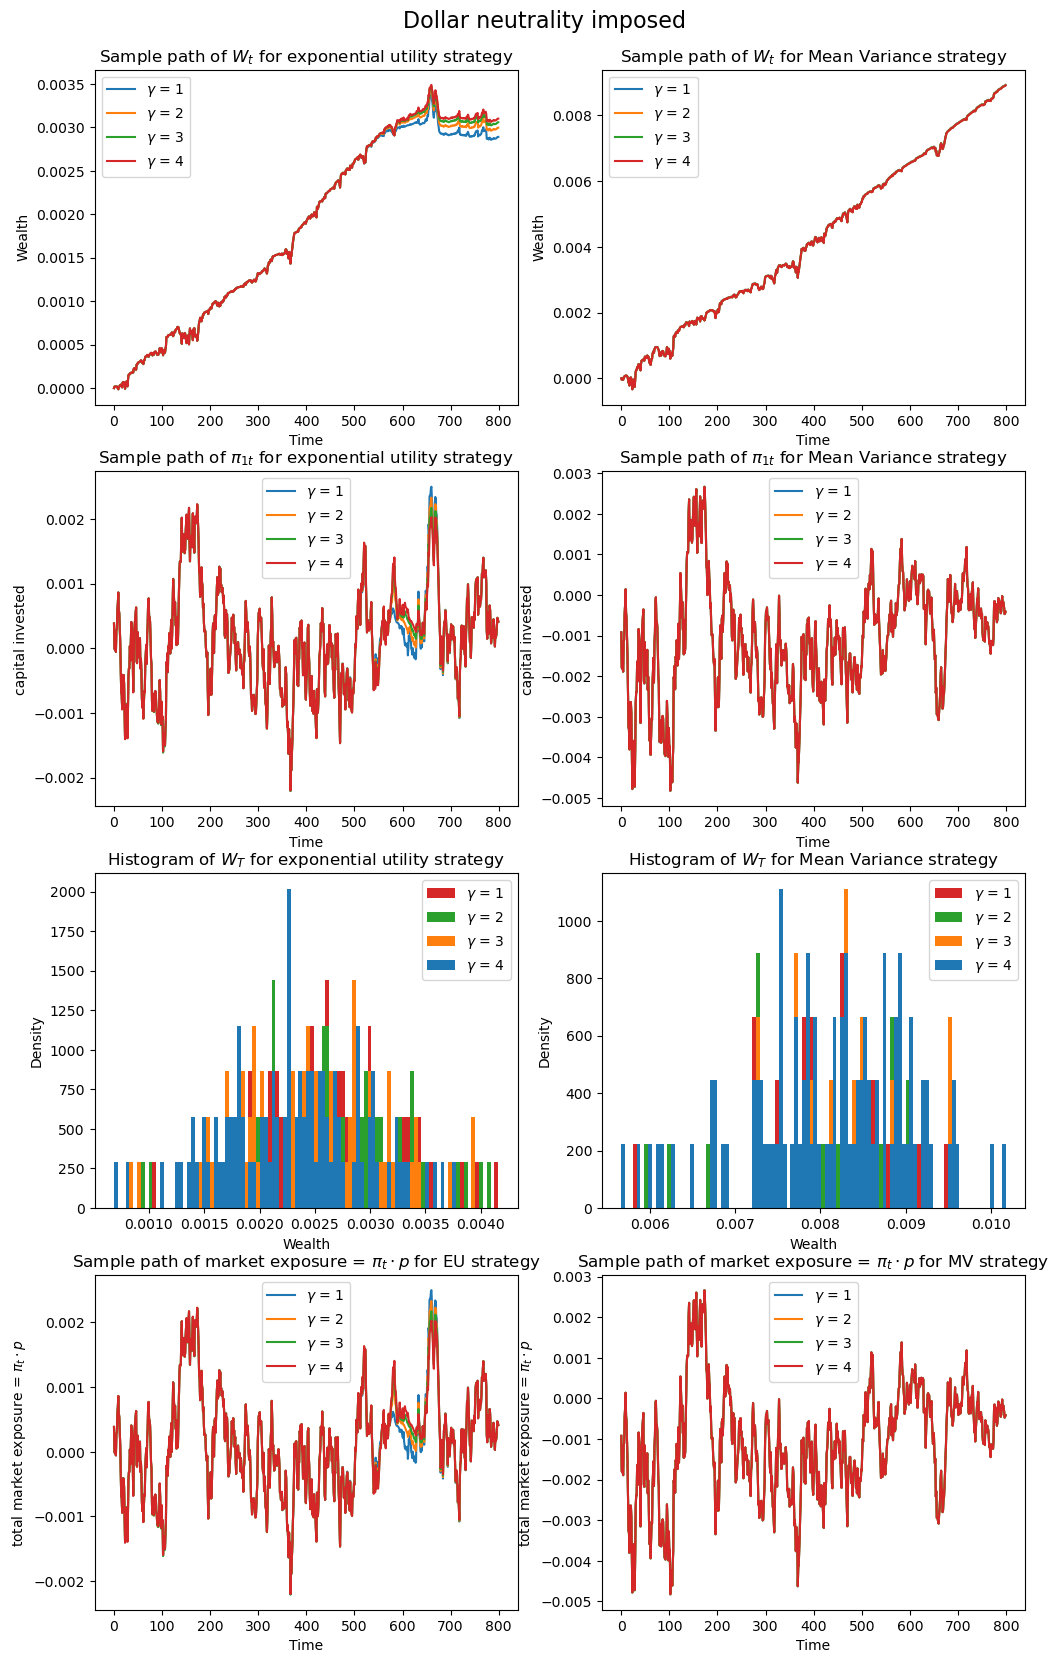

In [191]:
fig, ax = plt.subplots(4,2,figsize=(12,20))
fig.suptitle('Dollar neutrality imposed', fontsize=16, y = 0.91)
# plot a sample path of the wealth
ax[0,0].plot(Wealth_EU[-1,:,:])
ax[0,0].legend([r'$\gamma$ = 1',r'$\gamma$ = 2',r'$\gamma$ = 3',r'$\gamma$ = 4'])
ax[0,0].set_title(r'Sample path of $W_t$ for exponential utility strategy')
ax[0,0].set_ylabel('Wealth')
ax[0,0].set_xlabel('Time')

ax[0,1].plot(Wealth_MV[-1,:,:])
ax[0,1].legend([r'$\gamma$ = 1',r'$\gamma$ = 2',r'$\gamma$ = 3',r'$\gamma$ = 4'])
ax[0,1].set_title(r'Sample path of $W_t$ for Mean Variance strategy')
ax[0,1].set_ylabel('Wealth')
ax[0,1].set_xlabel('Time')

# plot a sample path of the capital invested in the first asset 
ax[1,0].plot(pi_EU[0,:,:])
ax[1,0].legend([r'$\gamma$ = 1',r'$\gamma$ = 2',r'$\gamma$ = 3',r'$\gamma$ = 4'])
ax[1,0].set_title(r'Sample path of $\pi_{1t}$ for exponential utility strategy')
ax[1,0].set_ylabel('capital invested')
ax[1,0].set_xlabel('Time')

ax[1,1].plot(pi_MV[0,:,:])
ax[1,1].legend([r'$\gamma$ = 1',r'$\gamma$ = 2',r'$\gamma$ = 3',r'$\gamma$ = 4'])
ax[1,1].set_title(r'Sample path of $\pi_{1t}$ for Mean Variance strategy')
ax[1,1].set_ylabel('capital invested')
ax[1,1].set_xlabel('Time')


# plot the density
ax[2,0].hist(Wealth_EU[:,-1,:],bins=100, density=True,histtype='stepfilled')
ax[2,0].legend([r'$\gamma$ = 1',r'$\gamma$ = 2',r'$\gamma$ = 3',r'$\gamma$ = 4'])
ax[2,0].set_title(r'Histogram of $W_T$ for exponential utility strategy')
ax[2,0].set_xlabel('Wealth')
ax[2,0].set_ylabel('Density')

ax[2,1].hist(Wealth_MV[:,-1,:],bins=100, density=True,histtype='stepfilled')
ax[2,1].legend([r'$\gamma$ = 1',r'$\gamma$ = 2',r'$\gamma$ = 3',r'$\gamma$ = 4'])
ax[2,1].set_title(r'Histogram of $W_T$ for Mean Variance strategy')
ax[2,1].set_xlabel('Wealth')
ax[2,1].set_ylabel('Density')

# plot the total market allocation
ax[3,0].plot(pi_EU.sum(axis=0))
ax[3,0].legend([r'$\gamma$ = 1',r'$\gamma$ = 2',r'$\gamma$ = 3',r'$\gamma$ = 4'])
ax[3,0].set_title(r'Sample path of market exposure = $\pi_t \cdot p$ for EU strategy')
ax[3,0].set_xlabel('Time')
ax[3,0].set_ylabel(r'total market exposure = $\pi_t \cdot p$ ')

ax[3,1].plot(pi_MV.sum(axis=0))
ax[3,1].legend([r'$\gamma$ = 1',r'$\gamma$ = 2',r'$\gamma$ = 3',r'$\gamma$ = 4'])
ax[3,1].set_title(r'Sample path of market exposure = $\pi_t \cdot p$ for MV strategy')
ax[3,1].set_xlabel('Time')
ax[3,1].set_ylabel(r'total market exposure = $\pi_t \cdot p$ ')

plt.show()

#### 2.3 Quadratic transaction costs

### Part 3: Deep reinforcement learning applied to the monte carlo paths

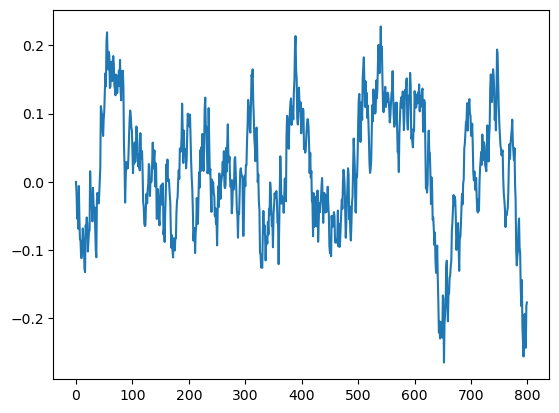

In [179]:
p = np.ones(N)
process  = ornstein_uhlenbeck_process(theta,mu,sigma,delta_t)
test_env = TradingEnvironment(process,T,0,p)
test_env.eval()

done = False
while not done:
    state, reward, done, _ = test_env.step(np.ones(N))
plt.plot(test_env.W.transpose())

In [180]:
r  = 0.02 # 0.2% interest rate
p  = np.ones((N,1)) #simplification in this model the asset prices themselves are assumed to be mean reverting
M  = 100 # amount of monte carlo simulations done
W0 = 0
process = ornstein_uhlenbeck_process(theta,mu,sigma,delta_t)
env     = TradingEnvironment(process,T,r,p)

def init_weights(m):
    """ Initializes the ANNs weights with a relevant distribution. """
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0)

#### 3.1 Actor-Critic reinforcement learning 

First the policy and value models need to be created 

C-RL converges for 1 asset with hidden_dim=5 and learning_rate= 0.003
but does not converge for 100 assets with hidden_dim=500 and learning rate =0.0003

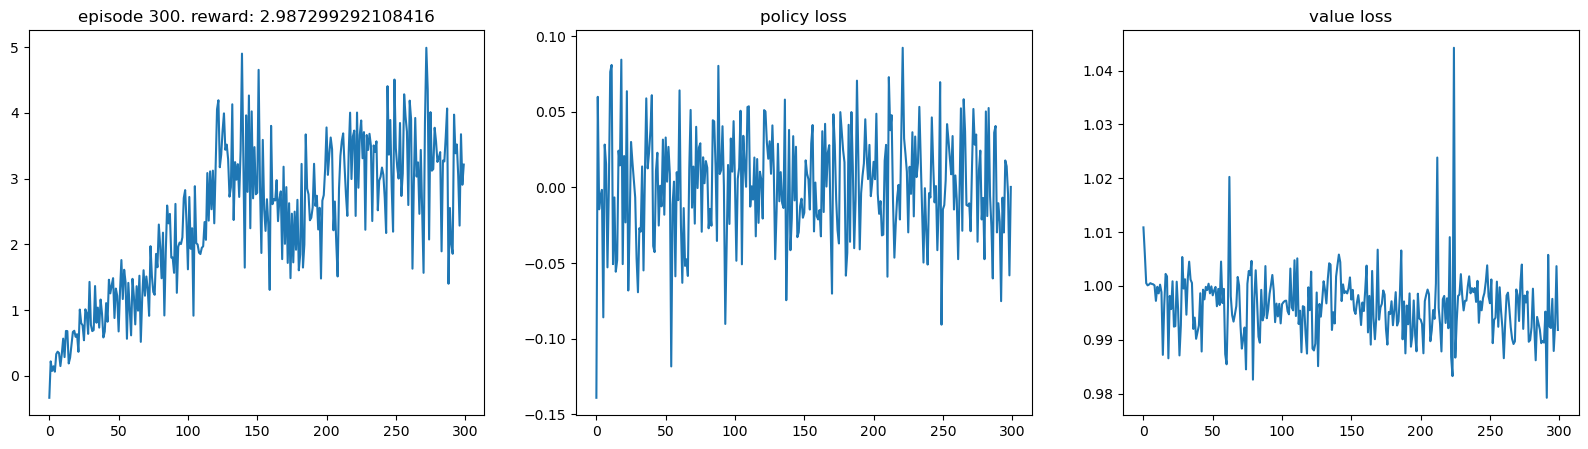

In [103]:
LEARNING_RATE = 0.03
MAX_EPISODES = 300
DISCOUNT_FACTOR = 0
N_TRIALS = 25

INPUT_DIM  = N#2 * N + 1# first N input values is X_t and the next is pi_t
HIDDEN_DIM = 5
OUTPUT_DIM_ACTOR = N
OUTPUT_DIM_CRITIC = 1

policy_losses = []
value_losses = []
train_rewards = []
test_rewards = []

# init agent
actor = PolicyModel(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM_ACTOR)
critic = ValueModel(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM_CRITIC)
agent = ActorCritic(actor, critic)

agent.apply(init_weights)
optimizer = optim.Adam(agent.parameters(), lr = LEARNING_RATE)

process = ornstein_uhlenbeck_process(theta,mu,sigma,delta_t)
train_env = TradingEnvironment(process,T,r,p)
train_env.eval()
eval_env = TradingEnvironment(process,T,r,p)
eval_env.eval()

for episode in range(1, MAX_EPISODES+1):
    policy_loss, value_loss, train_reward = train(train_env, agent, optimizer, DISCOUNT_FACTOR)
    test_reward = evaluate(eval_env, agent, False)
    
    train_rewards.append(train_reward)
    test_rewards.append(test_reward)
    policy_losses.append(policy_loss)
    value_losses.append(value_loss)
    
    mean_train_rewards = np.mean(train_rewards[-N_TRIALS:])
    mean_test_rewards = np.mean(test_rewards[-N_TRIALS:])
    
    plot(episode, train_rewards, policy_losses, value_losses)

#### 3.2 Proximal Policy Optimisation (PPO)

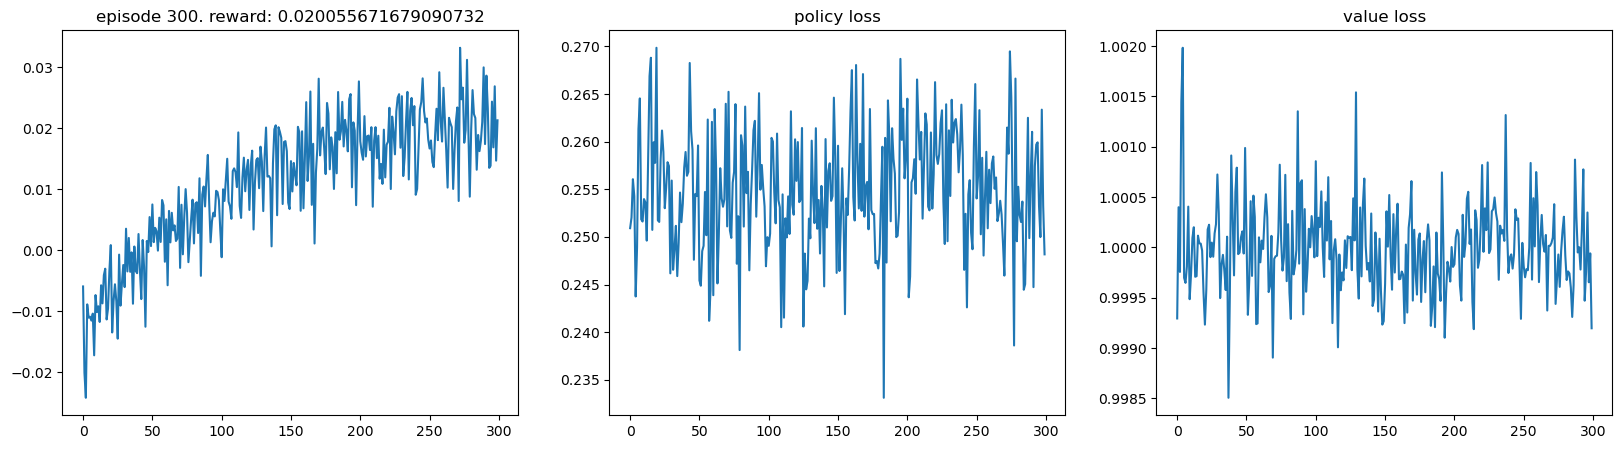

In [242]:
MAX_EPISODES = 300
LEARNING_RATE = 0.0001
DISCOUNT_FACTOR = 0
N_TRIALS = 25
PPO_STEPS = 5
PPO_CLIP = 0.2

INPUT_DIM  = N#2 * N + 1# first N input values is X_t and the next is pi_t
HIDDEN_DIM = 5
OUTPUT_DIM_ACTOR = N
OUTPUT_DIM_CRITIC = 1

policy_losses = []
value_losses = []
train_rewards = []
test_rewards = []

process = ornstein_uhlenbeck_process(theta,mu,sigma,delta_t)
r = 0
train_env = TradingEnvironment(process,T,r,p)
train_env.eval()
eval_env = TradingEnvironment(process,T,r,p)
eval_env.eval()

# init agent
actor = PolicyModel(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM_ACTOR,dropout=0)
critic = ValueModel(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM_CRITIC, dropout=0)
agent = ActorCritic(actor, critic)
agent.apply(init_weights)
optimizer = optim.Adam(agent.parameters(), lr = LEARNING_RATE)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

for episode in range(1, MAX_EPISODES+1):
    
    policy_loss, value_loss, train_reward = train_ppo(train_env, agent, optimizer,scheduler, DISCOUNT_FACTOR, PPO_STEPS, PPO_CLIP)
    
    test_reward = evaluate(eval_env, agent)
    
    train_rewards.append(train_reward)
    test_rewards.append(test_reward)
    policy_losses.append(policy_loss)
    value_losses.append(value_loss)

    
    mean_train_rewards = np.mean(train_rewards[-N_TRIALS:])
    mean_test_rewards = np.mean(test_rewards[-N_TRIALS:])
    
    plot(episode, test_rewards, policy_losses, value_losses)

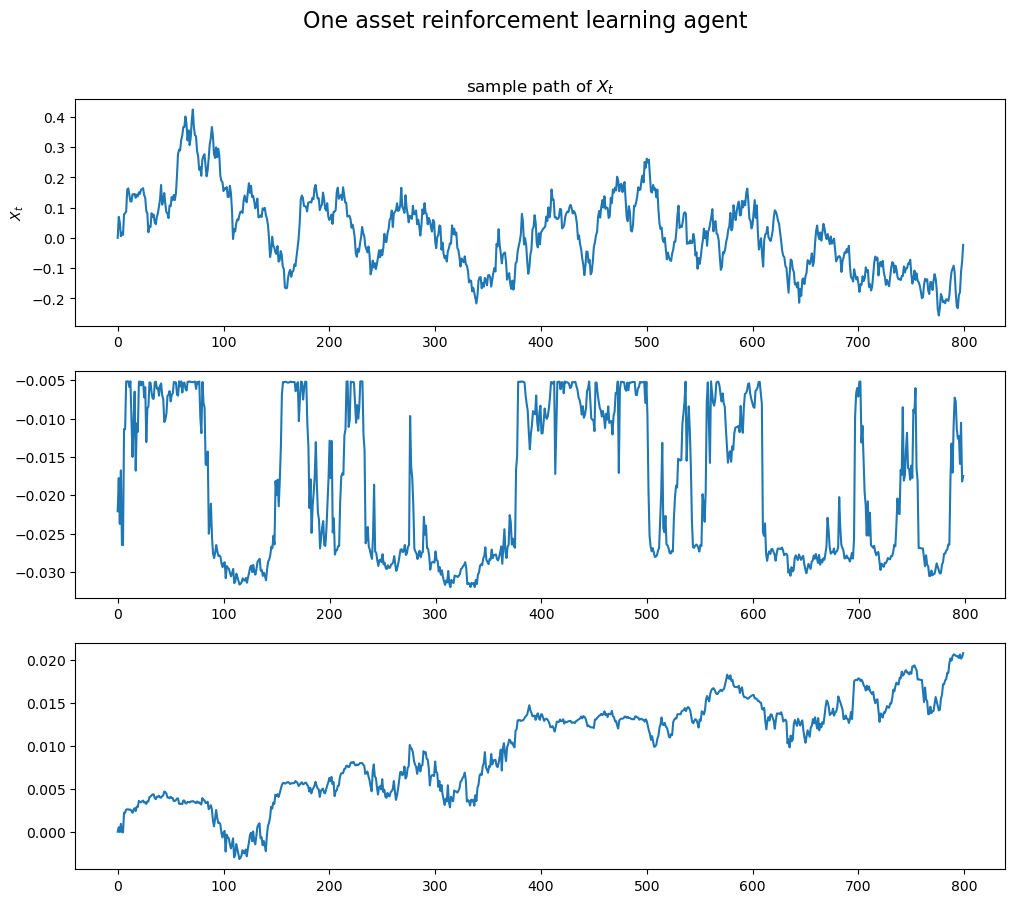

In [245]:
state = train_env.reset()
done = False
val_predictions = []
while not done:
    state = torch.FloatTensor(state[:N]).unsqueeze(0)
    #state = torch.FloatTensor(state).unsqueeze(0) #TODO: change state

    action, _, value_pred = agent.forward(state)
    val_predictions.append(value_pred.detach().item())
    state, reward, done, _ = train_env.step(action.detach().numpy())
    
fig, ax = plt.subplots(3,1,figsize=(12,10))
fig.suptitle('One asset reinforcement learning agent', fontsize=16, y = 0.97)
# plot a sample path of the wealth
ax[0].plot(env.X.transpose())
ax[0].set_title(r'sample path of $X_t$')
ax[0].set_ylabel(r'$X_t$')
#ax[0].set_xlabel('Time')
ax[1].plot(np.array(train_env.alloc).reshape(-1))
ax[2].plot(train_env.W)

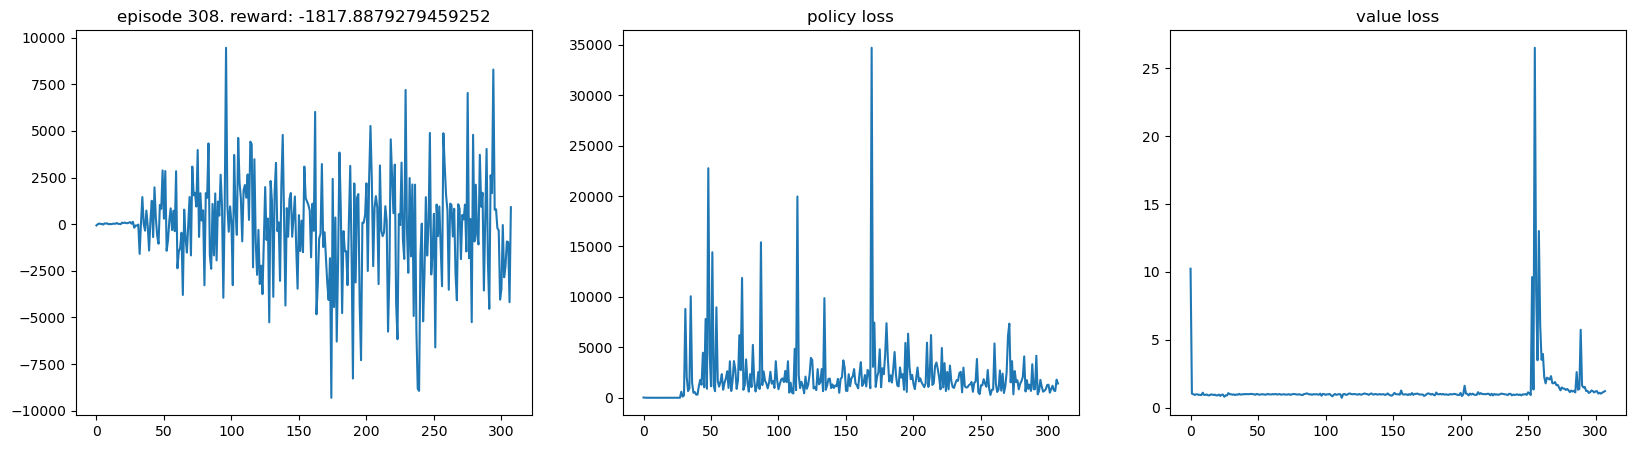

KeyboardInterrupt: 

In [90]:
MAX_EPISODES = 1000
LEARNING_RATE = 0.001
DISCOUNT_FACTOR = 0.9
N_TRIALS = 25
PPO_STEPS = 10
PPO_CLIP = 0.2

INPUT_DIM  = N#2 * N + 1# first N input values is X_t and the next is pi_t
HIDDEN_DIM = 250
OUTPUT_DIM_ACTOR = N
OUTPUT_DIM_CRITIC = 1

policy_losses = []
value_losses = []
train_rewards = []
test_rewards = []

process = ornstein_uhlenbeck_process(theta,mu,sigma,delta_t)
train_env = TradingEnvironment(process,T,r,p)
train_env.eval()
eval_env = TradingEnvironment(process,T,r,p)
eval_env.eval()

# init agent
actor = PolicyModel(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM_ACTOR)
critic = ValueModel(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM_CRITIC)
agent = ActorCritic(actor, critic)
agent.apply(init_weights)
optimizer = optim.Adam(agent.parameters(), lr = LEARNING_RATE)

for episode in range(1, MAX_EPISODES+1):
    
    policy_loss, value_loss, train_reward = train_ppo(train_env, agent, optimizer, DISCOUNT_FACTOR, PPO_STEPS, PPO_CLIP)
    
    test_reward = evaluate(eval_env, agent)
    
    train_rewards.append(train_reward)
    test_rewards.append(test_reward)
    policy_losses.append(policy_loss)
    value_losses.append(value_loss)

    
    mean_train_rewards = np.mean(train_rewards[-N_TRIALS:])
    mean_test_rewards = np.mean(test_rewards[-N_TRIALS:])
    
    plot(episode, test_rewards, policy_losses, value_losses)